In [1]:
# import necessary modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # plot
import os
import re

pd.options.display.max_columns=500

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA


In [2]:
#Read the file
fifa=pd.read_csv('fifadata.csv',index_col=0)
pd.set_option('display.max_columns',100)
#fifa.head()

In [3]:
#cleaning columns
cc=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW','LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

for i in cc:
    fifa[i]=fifa[i].str.split('+',n=1,expand=True)[0]
    fifa[i]=pd.to_numeric(fifa[i])

In [4]:
# combine the position attributes as per pitch area
fifa['Forward'] = fifa.loc[:,'LS':'RW'].astype('float64').mean(axis=1)
fifa['Midfield'] = fifa.loc[:,'LAM':'RM'].astype('float64').mean(axis=1)
fifa['Defense'] = fifa.loc[:,'LWB':'RB'].astype('float64').mean(axis=1)
fifa['GoalKeeper'] = fifa.loc[:,'GKDiving':'GKReflexes'].astype('float64').mean(axis=1)

# drop the columns that are replaced above
fifa.drop(fifa.loc[:,'LS':'RB'].columns.tolist(), axis=1, inplace=True)
fifa.drop(fifa.loc[:,'GKDiving':'GKReflexes'].columns.tolist(), axis=1, inplace=True)

In [5]:
fifa["Club"].fillna("Freelance", inplace = True) 

In [6]:
#renaming columns
colnew = []

for col in fifa.columns:
    colnew.append(col.replace(' ', ''))
    
fifa.columns = colnew

In [7]:
fifa.Wage=fifa.Wage.replace(['M', 'K', '€|\.'], ['000000', '000', ''], regex = True)
fifa.Wage=fifa.Wage.astype('int64')

In [8]:
def cleaning_value(x):
    if '€' in str(x) and 'M' in str(x):
        c = str(x).replace('€' , '')
        c = str(c).replace('M' , '')
        c = float(c) * 1000000
        
    else:
        c = str(x).replace('€' , '')
        c = str(c).replace('K' , '')
        c = float(c) * 1000
            
    return c

fn = lambda x : cleaning_value(x)

fifa['VALUE'] = fifa['Value'].apply(fn)
fifa.VALUE=fifa.VALUE.astype('int64')

fifa=fifa.drop('Value', axis=1)

In [9]:
# Cleaning columns
fifa['Weight']=fifa['Weight'].str.replace('lbs','')
fifa['Height']=fifa['Height'].str.replace("'",'.')

# Changing datatypes from Object to float
fifa.Height = fifa.Height.astype(float)
fifa.Weight = fifa.Weight.astype(float)

In [10]:
#Split the Work Rate Column in two
tempwork = fifa["WorkRate"].str.split("/ ", n = 1, expand = True) 
#Create new column for first work rate
fifa["WorkrateAttack"]= tempwork[0]   
#Create new column for second work rate
fifa["WorkrateDefense"]= tempwork[1]

fifa=fifa.drop('WorkRate', axis=1)

In [11]:
fifa['BodyType']=fifa['BodyType'].str.replace('Messi','Lean')
fifa['BodyType']=fifa['BodyType'].str.replace('Neymar','Normal')
fifa['BodyType']=fifa['BodyType'].str.replace('Courtois','Normal')
fifa['BodyType']=fifa['BodyType'].str.replace('C. Ronaldo','Lean')
fifa['BodyType']=fifa['BodyType'].str.replace('PLAYER_BODY_TYPE_25','Stocky')
fifa['BodyType']=fifa['BodyType'].str.replace('Akinfenwa','Stocky')
fifa['BodyType']=fifa['BodyType'].str.replace('Shaqiri','Stocky')

In [12]:
# removing the columns that do not provide any additional information
fifa.drop(['ID','Photo','Name','RealFace','Flag','LoanedFrom','ClubLogo','JerseyNumber','ReleaseClause', 
           'Joined','ContractValidUntil','Club','Nationality'], inplace=True, axis=1)

In [13]:
fifa.dropna(axis=0,how='all' ,subset=['Finishing'], inplace=True)

In [16]:
# imputing data in Position column based on Player attributes that can help us identify which position is suitable 
#for the player 

from sklearn.tree import DecisionTreeClassifier

col = fifa.loc[:,'Crossing':'SlidingTackle'].columns
# filter data for model building
X = fifa[col][fifa['Position'].notna()]
y = fifa.Position[fifa['Position'].notna()]

# create test data with unknown fuelType fields
xt = fifa[col][fifa['Position'].isna()]
        
# build a decision tree model
dtree = DecisionTreeClassifier().fit(X,y)

# predict on test data
pos_pred = dtree.predict(xt)

# fill the missing values with the predicted values
fifa.Position[fifa['Position'].isna()] = pos_pred
# fifa.Position.isna().sum()

In [17]:
# fwd = ['Crossing', 'Finishing', 'ShortPassing', 'Dribbling', 'Curve', 'FKAccuracy', 'Acceleration', 
#        'SprintSpeed', 'ShotPower', 'BallControl', 'Penalties']
# mid = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 
#        'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 
#        'Balance','ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 
#        'Positioning', 'Vision', 'Penalties']
# des = ['Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Jumping', 'Stamina', 'Strength', 
#        'LongShots', 'HeadingAccuracy']

# x = fifa[fwd][fifa['Forward'].isna()].mean(axis=1).astype('int64')
# fifa.Forward[fifa['Forward'].isna()] = x

# x = fifa[mid][fifa['Midfield'].isna()].mean(axis=1).astype('int64')
# fifa.Midfield[fifa['Midfield'].isna()] = x

# x = fifa[des][fifa['Defense'].isna()].mean(axis=1).astype('int64')
# fifa.Defense[fifa['Defense'].isna()] = x

In [14]:
fifa.dropna(axis=0,inplace=True)

In [17]:
#fifa.isna().sum()

In [25]:
# Checking Co-relations
ad=fifa.corr()
ad.style.background_gradient(cmap='coolwarm')

# fifa=fifa.drop(['Midfield','Dribbling','BallControl','Special','LongShots','Positioning','Interceptions','SkillMoves','Forward',
#                 'Crossing','ShortPassing'], axis=1)

In [15]:
# One Hot Encoding Categorical Variables
#fifa=pd.concat([pd.get_dummies(fifa['BodyType'], drop_first = True),fifa],axis=1).drop('BodyType',axis=1)

fifa=pd.concat([pd.get_dummies(fifa['PreferredFoot']),fifa],axis=1).drop('PreferredFoot',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['BodyType']),fifa],axis=1).drop('BodyType',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['WorkrateAttack']),fifa],axis=1).drop('WorkrateAttack',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['WorkrateDefense']),fifa],axis=1).drop('WorkrateDefense',axis=1)
fifa=pd.concat([pd.get_dummies(fifa['Position']),fifa],axis=1).drop('Position',axis=1)
#fifa=pd.concat([pd.get_dummies(fifa['Nationality']),fifa],axis=1).drop('Nationality',axis=1)
#fifa=pd.concat([pd.get_dummies(fifa['Club']),fifa],axis=1).drop('Club',axis=1)

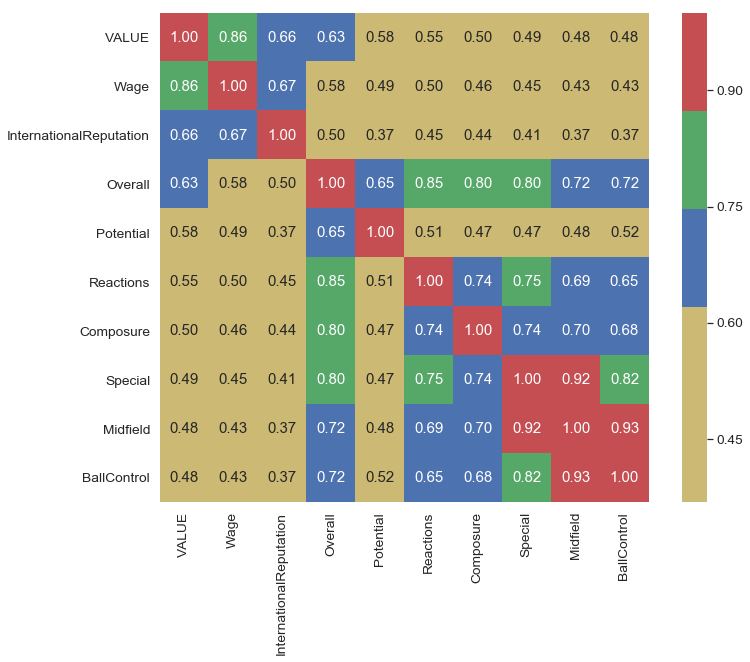

In [20]:
corr_mat = fifa.corr()
k=10
plt.figure(figsize=(12,9))
cols = corr_mat.nlargest(k, 'VALUE')['VALUE'].index
cm = np.corrcoef(fifa[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(cm, annot=True, fmt='.2f', annot_kws={'size':15}, yticklabels=cols.values, xticklabels=cols.values, cmap=['y','y','b','g','r'], square=True)
plt.show()

In [21]:
#fifa.shape

In [16]:
fifa=fifa[fifa.VALUE > 0]

In [18]:
fifa.skew().sort_values(ascending=False)[:10]

LF     32.533066
RF     31.497031
RAM    27.479877
LAM    27.479877
CF     14.565465
LWB    14.181670
RWB    13.416592
RS      8.730474
LS      8.619684
LDM     7.976826
dtype: float64

In [18]:
from scipy import stats

Value skew:  6.949720137704822
Value skew:  0.41554987751512423


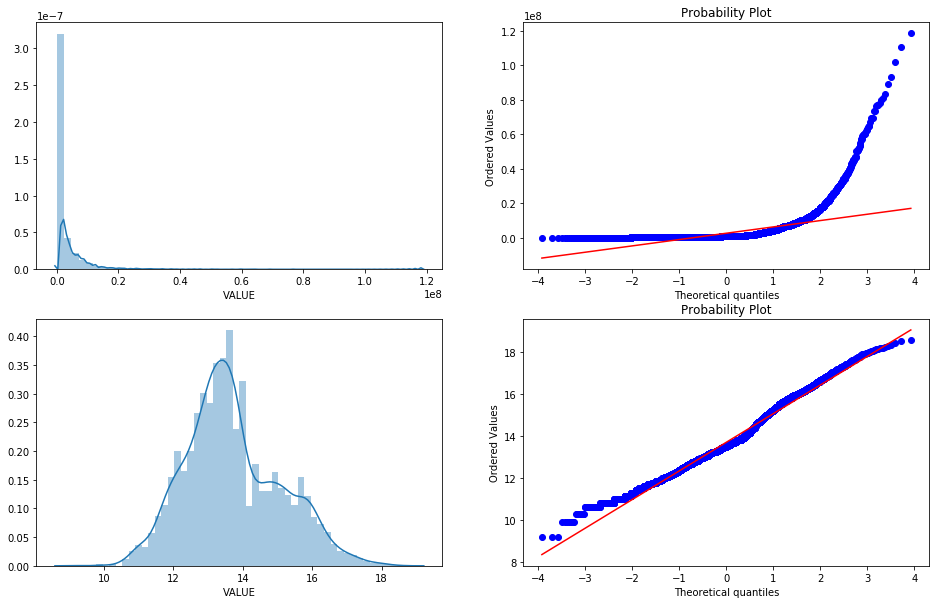

In [19]:
plt.subplots(figsize=(16,10))
plt.subplot(221)
sns.distplot(fifa['VALUE'])
print('Value skew: ',fifa.VALUE.skew())

plt.subplot(223)
d=np.log1p(fifa['VALUE'])
sns.distplot(d)
print('Value skew: ',d.skew())

plt.subplot(222)
stats.probplot(fifa.VALUE, plot=plt)

plt.subplot(224)
stats.probplot(d, plot=plt)


plt.show()

Wage skew:  7.801550711225325
Wage skew:  0.6893276290206956


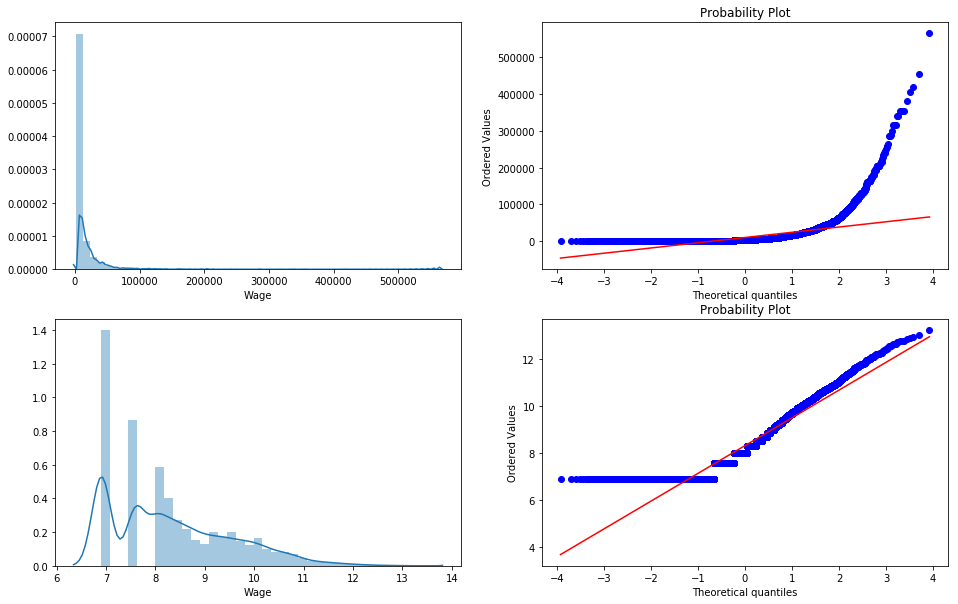

In [20]:
plt.subplots(figsize=(16,10))
plt.subplot(221)
sns.distplot(fifa.Wage)
print('Wage skew: ',fifa.Wage.skew())

plt.subplot(223)
w=np.log1p(fifa['Wage'])
sns.distplot(w)
print('Wage skew: ',w.skew())

plt.subplot(222)
stats.probplot(fifa.Wage, plot=plt)

plt.subplot(224)
stats.probplot(w, plot=plt)


plt.show()

In [17]:
# removing outliers from VALUE and Wage columns
q1wage=fifa.Wage.quantile(0.25)
q3wage=fifa.Wage.quantile(0.75)
iqrwage= q3wage - q1wage

# q1val=fifa.VALUE.quantile(0.25)
# q3val=fifa.VALUE.quantile(0.75)
# iqrval= q3val - q1val

upperwage= q3wage + iqrwage*1.5
# upperval= q3val + iqrval*1.5

fifa=fifa[(fifa.Wage <= upperwage)]

In [23]:
fifa.head()

,CAM,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,High,Low,Medium,High,Low,Medium,Lean,Normal,Stocky,Left,Right,Age,Overall,Potential,Wage,Special,InternationalReputation,WeakFoot,SkillMoves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Forward,Midfield,Defense,GoalKeeper,VALUE
76,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,34,86,86,21000,2058,4.0,4.0,4.0,5.70,150.0,77.0,70.0,54.0,90.0,74.0,90.0,80.0,70.0,85.0,92.0,70.0,67.0,79.0,86.0,84.0,65.0,47.0,55.0,58.0,71.0,58.0,66.0,81.0,93.0,71.0,89.0,67.0,57.0,56.0,78.625,83.50,68.6,9.0,21500000
109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,36,85,85,15000,2012,5.0,4.0,5.0,6.50,209.0,73.0,86.0,83.0,79.0,86.0,79.0,82.0,82.0,73.0,84.0,58.0,59.0,75.0,82.0,39.0,90.0,68.0,61.0,86.0,82.0,84.0,20.0,85.0,79.0,89.0,90.0,28.0,37.0,24.0,80.000,76.00,53.9,11.8,14000000
112,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,25,84,87,22000,2259,3.0,2.0,3.0,5.11,157.0,89.0,65.0,74.0,83.0,67.0,82.0,87.0,79.0,86.0,82.0,84.0,85.0,73.0,83.0,70.0,80.0,81.0,92.0,68.0,75.0,78.0,80.0,76.0,74.0,68.0,80.0,80.0,81.0,79.0,77.500,80.25,80.7,11.6,32000000
114,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,23,84,88,22000,2223,2.0,3.0,4.0,5.10,152.0,84.0,73.0,58.0,85.0,84.0,83.0,85.0,81.0,82.0,85.0,79.0,76.0,77.0,84.0,78.0,87.0,72.0,89.0,67.0,88.0,65.0,70.0,79.0,86.0,81.0,83.0,63.0,66.0,53.0,79.500,82.00,72.2,12.6,40500000
166,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,24,83,90,18000,2142,2.0,4.0,4.0,6.30,176.0,78.0,80.0,77.0,81.0,76.0,82.0,86.0,87.0,79.0,84.0,77.0,76.0,76.0,79.0,65.0,84.0,58.0,76.0,72.0,88.0,67.0,58.0,86.0,81.0,71.0,74.0,55.0,62.0,42.0,80.625,80.00,67.1,11.8,36500000


In [50]:
fifa.reset_index(drop=True).head()

,CAM,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,High,Low,Medium,High,Low,Medium,Lean,Normal,Stocky,Left,Right,Age,Overall,Potential,Wage,Special,InternationalReputation,WeakFoot,SkillMoves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Forward,Midfield,Defense,GoalKeeper,VALUE
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,34,86,86,21000,2058,4.000000,4.000000,4.000000,5.700000,150.000000,77.000000,70.000000,54.000000,90.000000,74.000000,90.000000,80.000000,70.000000,85.000000,92.000000,70.000000,67.000000,79.000000,86.000000,84.000000,65.000000,47.000000,55.000000,58.000000,71.000000,58.000000,66.000000,81.000000,93.000000,71.000000,89.000000,67.000000,57.000000,56.000000,78.625000,83.500000,68.600000,9.000000,21500000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,36,85,85,15000,2012,5.000000,4.000000,5.000000,6.500000,209.000000,73.000000,86.000000,83.000000,79.000000,86.000000,79.000000,82.000000,82.000000,73.000000,84.000000,58.000000,59.000000,75.000000,82.000000,39.000000,90.000000,68.000000,61.000000,86.000000,82.000000,84.000000,20.000000,85.000000,79.000000,89.000000,90.000000,28.000000,37.000000,24.000000,80.000000,76.000000,53.900000,11.800000,14000000
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,24,83,90,18000,2142,2.000000,4.000000,4.000000,6.300000,176.000000,78.000000,80.000000,77.000000,81.000000,76.000000,82.000000,86.000000,87.000000,79.000000,84.000000,77.000000,76.000000,76.000000,79.000000,65.000000,84.000000,58.000000,76.000000,72.000000,88.000000,67.000000,58.000000,86.000000,81.000000,71.000000,74.000000,55.000000,62.000000,42.000000,80.625000,80.000000,67.100000,11.800000,36500000
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,24,83,86,20000,2015,3.000000,4.000000,4.000000,5.110000,161.000000,78.000000,79.000000,53.000000,77.000000,68.000000,88.000000,81.000000,78.000000,71.000000,87.000000,89.000000,87.000000,88.000000,83.000000,71.000000,84.000000,68.000000,74.000000,59.000000,75.000000,61.000000,18.000000,81.000000,71.000000,74.000000,75.000000,58.000000,39.000000,26.000000,80.125000,77.625000,56.400000,9.800000,33000000
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,26,83,86,21000,2028,3.000000,3.000000,3.000000,6.200000,183.000000,50.000000,61.000000,78.000000,82.000000,55.000000,76.000000,48.000000,53.000000,79.000000,78.000000,63.000000,68.000000,58.000000,76.000000,60.000000,76.000000,67.000000,83.000000,89.000000,65.000000,85.000000,84.000000,69.000000,73.000000,52.000000,84.000000,83.000000,84.000000,75.000000,71.250000,74.000000,78.600000,11.600000,27000000


In [18]:
Y=np.log(fifa.VALUE)
X=fifa.drop(['VALUE'], axis=1)
#X = pd.get_dummies(X)

In [27]:
# Normalizing dataset
from sklearn.preprocessing import MinMaxScaler

ms=MinMaxScaler()
X = ms.fit_transform(X)

In [19]:
#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=32)

In [20]:
#Applying Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
predy = model.predict(X_test)
predx = model.predict(X_train)

#Finding the r2 score and root mean squared error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#print("lr.coef_: {}".format(model.coef_))
#print("lr.intercept_: {}".format(model.intercept_))

train_rmse= np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))
train_r2 = model.score(X_train, y_train)
test_rmse= np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))
test_r2 = model.score(X_test, y_test)
perc = ((train_rmse-test_rmse)/train_rmse)*100

Train_adjusted_r2 = 1 - ((1 - train_r2)*((X_train.shape[0] - 1)/(X_train.shape[0]-(X_train.shape[1]+1))))
Test_adjusted_r2= 1 - ((1 - test_r2)*((X_test.shape[0] - 1)/(X_test.shape[0]-(X_test.shape[1]+1))))

print(f'Train (R-Squared): {train_r2:0.4f}; || Train Adj_R-Squared: {Train_adjusted_r2:0.4f}')
print(f'Test  (R-Squared): {test_r2:0.4f}; || Test Adj_R-Squared:  {Test_adjusted_r2:0.4f}')
#print("Train (R-Squared): {:.3f}".format(model.score(X_train, y_train)))
#print("Test set score: {:.7f}".format(model.score(X_test, y_test)))
#print('Test  (R-Squared): '+str(r2_score(y_test, predy)))
#print('Test  (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))))
#print('Train (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))))
print('RMSE on train:',train_rmse)
print('RMSE on test_:',test_rmse)
print(f'RMSE difference(test-train): {train_rmse-test_rmse}',{perc})
#print('Percentage difference: ', perc)
print("Mean Absolute Error(MAE): ",mean_absolute_error(np.exp(y_test), np.exp(predy)))

# Evaluating Test Results
print('******* EVALUATING TEST RESULTS ***********')
pd.set_option('float_format', '{:f}'.format)
result = pd.DataFrame({'Actual_Value': np.exp(y_test), 'Predicted_Value': np.exp(predy)})
result.Predicted_Value = result.Predicted_Value.astype('int64')
result.Actual_Value = result.Actual_Value.astype('int64')
result['Difference'] = result.Actual_Value - result.Predicted_Value
result['Perc_of_error']= round(abs(((result.Actual_Value - result.Predicted_Value)/result.Actual_Value)*100))
print(result.head(6))

percenta= pd.DataFrame(result.Perc_of_error.value_counts())
percenta['Percentage_Accuracy']= (percenta.Perc_of_error/sum(percenta.Perc_of_error))*100
print(percenta.sort_index(axis = 0)[:10])
print(" %f percent of test data has error less than 12 percent: " % percenta.Percentage_Accuracy.sort_index(axis = 0)[:13].sum())

result['over_12'] = np.where((result['Perc_of_error'] >= 12), 1,0).astype('int64')
result.head()
result.loc[result['over_12'] == 1][:10]

# train data evaluation
pd.set_option('float_format', '{:f}'.format)
resulttrain = pd.DataFrame({'Actual_Value': np.exp(y_train), 'Predicted_Value': np.exp(predx)})
resulttrain.Predicted_Value = resulttrain.Predicted_Value.astype('int64')
resulttrain.Actual_Value = resulttrain.Actual_Value.astype('int64')
resulttrain['Difference'] = resulttrain.Actual_Value - resulttrain.Predicted_Value
resulttrain['Perc_of_error']= round(abs(((resulttrain.Actual_Value - resulttrain.Predicted_Value)/resulttrain.Actual_Value)*100))
#print(resulttrain.head(6))

percentage= pd.DataFrame(resulttrain.Perc_of_error.value_counts())
percentage['Percentage_Accuracy']= (percentage.Perc_of_error/sum(percentage.Perc_of_error))*100
print(percentage.sort_index(axis = 0)[:10])
print(" %f percent of train data has error less than 12 percent: " % percentage.Percentage_Accuracy.sort_index(axis = 0)[:13].sum())

resulttrain['over_12'] = np.where((resulttrain['Perc_of_error'] >= 12), 1,0).astype('int64')
resulttrain.head()
resulttrain.loc[resulttrain['over_12'] == 1][:10]

Train (R-Squared): 0.9695; || Train Adj_R-Squared: 0.9693
Test  (R-Squared): 0.9660; || Test Adj_R-Squared:  0.9650
RMSE on train: 603749.2249336903
RMSE on test_: 480889.48021653923
RMSE difference(test-train): 122859.74471715104 {20.349466242485814}
Mean Absolute Error(MAE):  217257.62018019755
******* EVALUATING TEST RESULTS ***********
       Actual_Value  Predicted_Value  Difference  Perc_of_error
15620        279999           297643      -17644       6.000000
9247         999999          1088629      -88630       9.000000
5872        1199999          1507129     -307130      26.000000
2837        5499999          4664356      835643      15.000000
11769        874999           821545       53454       6.000000
12730        550000           476283       73717      13.000000
           Perc_of_error  Percentage_Accuracy
0.000000              75             2.636204
1.000000             140             4.920914
2.000000             133             4.674868
3.000000             142  

,Actual_Value,Predicted_Value,Difference,Perc_of_error,over_12
15112,350000,402001,-52001,15.000000,1
5746,1100000,1360856,-260856,24.000000,1
3614,2399999,2096117,303882,13.000000,1
6517,1699999,1965952,-265953,16.000000,1
12056,550000,646782,-96782,18.000000,1
13404,400000,448468,-48468,12.000000,1
7317,269999,461799,-191800,71.000000,1
12620,725000,541854,183146,25.000000,1
12770,725000,633991,91009,13.000000,1
2459,6999999,4995186,2004813,29.000000,1


In [30]:
result['over_12'] = np.where((result['Perc_of_error'] >= 12), 1,0).astype('int64')
result.head()
result.loc[result['over_12'] == 1][:10]

,Actual_Value,Predicted_Value,Difference,Perc_of_error,over_12
9627,625000,531053,93947,15.000000,1
8332,975000,1215592,-240592,25.000000,1
16260,179999,229073,-49074,27.000000,1
3798,2399999,1727705,672294,28.000000,1
2357,3499999,2431700,1068299,31.000000,1
7246,924999,1101418,-176419,19.000000,1
15437,230000,267030,-37030,16.000000,1
11625,474999,416828,58171,12.000000,1
4430,2599999,3140714,-540715,21.000000,1
17502,130000,110448,19552,15.000000,1


In [31]:
# train data evaluation
pd.set_option('float_format', '{:f}'.format)
resulttrain = pd.DataFrame({'Actual_Value': np.exp(y_train), 'Predicted_Value': np.exp(predx)})
resulttrain.Predicted_Value = resulttrain.Predicted_Value.astype('int64')
resulttrain.Actual_Value = resulttrain.Actual_Value.astype('int64')
resulttrain['Difference'] = resulttrain.Actual_Value - resulttrain.Predicted_Value
resulttrain['Perc_of_error']= round(abs(((resulttrain.Actual_Value - resulttrain.Predicted_Value)/resulttrain.Actual_Value)*100))
print(resulttrain.head(6))

percentage= pd.DataFrame(resulttrain.Perc_of_error.value_counts())
percentage['Percentage_Accuracy']= (percentage.Perc_of_error/sum(percentage.Perc_of_error))*100
print(percentage.sort_index(axis = 0)[:10])
print(" %f percent of train data has error less than 12 percent: " % percentage.Percentage_Accuracy.sort_index(axis = 0)[:13].sum())

resulttrain['over_12'] = np.where((resulttrain['Perc_of_error'] >= 12), 1,0).astype('int64')
resulttrain.head()
resulttrain.loc[resulttrain['over_12'] == 1][:10]

       Actual_Value  Predicted_Value  Difference  Perc_of_error
9214         474999           430059       44940       9.000000
3832        2800000          2603743      196257       7.000000
3688        3399999          3237248      162751       5.000000
12552        800000           724447       75553       9.000000
14782        424999           319593      105406      25.000000
7042         675000           785612     -110612      16.000000
           Perc_of_error  Percentage_Accuracy
0.000000             250             2.227767
1.000000             540             4.811976
2.000000             512             4.562467
3.000000             505             4.500089
4.000000             541             4.820888
5.000000             474             4.223846
6.000000             465             4.143646
7.000000             493             4.393156
8.000000             478             4.259490
9.000000             447             3.983247
10.000000            418             3.724826


,Actual_Value,Predicted_Value,Difference,Perc_of_error,over_12
14782,424999,319593,105406,25.000000,1
7042,675000,785612,-110612,16.000000,1
7262,975000,1097124,-122124,13.000000,1
3936,3599999,2785237,814762,23.000000,1
11906,675000,759955,-84955,13.000000,1
16603,219999,255050,-35051,16.000000,1
17415,149999,113510,36489,24.000000,1
3102,3000000,2150164,849836,28.000000,1
10936,750000,889346,-139346,19.000000,1
1851,8500000,6215632,2284368,27.000000,1


In [40]:
y_train.shape

(11222,)

In [21]:
Train= pd.concat([X_train.reset_index(drop=True),np.exp(y_train).reset_index(drop=True)],axis=1)
# df = pd.concat([T1.reset_index(drop=True),T2.reset_index(drop=True)], axis=1)

In [24]:
pd.concat([Train.reset_index(drop=True), result.Predicted_Value.reset_index(drop=True)],axis=1)

,CAM,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,High,Low,Medium,High,Low,Medium,Lean,Normal,Stocky,Left,Right,Age,Overall,Potential,Wage,Special,InternationalReputation,WeakFoot,SkillMoves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Forward,Midfield,Defense,GoalKeeper,VALUE,Predicted_Value
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,19,60,72,1000,1590,1.000000,4.000000,3.000000,5.700000,139.000000,56.000000,50.000000,47.000000,59.000000,28.000000,63.000000,48.000000,38.000000,55.000000,66.000000,69.000000,76.000000,75.000000,52.000000,89.000000,47.000000,63.000000,82.000000,29.000000,34.000000,62.000000,56.000000,46.000000,59.000000,45.000000,63.000000,33.000000,62.000000,57.000000,55.000000,58.500000,55.900000,8.800000,350000.000000,297643.000000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,21,73,84,18000,1686,1.000000,4.000000,3.000000,6.400000,194.000000,39.000000,74.000000,76.000000,64.000000,63.000000,71.000000,53.000000,32.000000,41.000000,67.000000,74.000000,86.000000,63.000000,65.000000,46.000000,70.000000,75.000000,73.000000,85.000000,64.000000,67.000000,24.000000,72.000000,58.000000,65.000000,61.000000,24.000000,26.000000,22.000000,69.375000,62.750000,46.900000,9.400000,7000000.000000,1088629.000000
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,20,57,70,1000,1381,1.000000,3.000000,2.000000,6.400000,172.000000,42.000000,20.000000,53.000000,35.000000,22.000000,38.000000,33.000000,32.000000,36.000000,30.000000,72.000000,74.000000,70.000000,53.000000,56.000000,33.000000,68.000000,58.000000,72.000000,26.000000,64.000000,54.000000,41.000000,39.000000,33.000000,46.000000,56.000000,58.000000,56.000000,39.875000,39.750000,52.000000,11.400000,180000.000000,1507129.000000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,27,69,69,1000,1686,1.000000,2.000000,3.000000,5.110000,181.000000,53.000000,73.000000,65.000000,61.000000,70.000000,66.000000,53.000000,51.000000,43.000000,70.000000,81.000000,78.000000,71.000000,70.000000,66.000000,53.000000,67.000000,68.000000,64.000000,54.000000,65.000000,34.000000,76.000000,53.000000,61.000000,64.000000,21.000000,23.000000,25.000000,67.375000,62.000000,47.100000,10.200000,1100000.000000,4664356.000000
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,32,72,72,21000,1911,1.000000,3.000000,3.000000,5.500000,148.000000,67.000000,67.000000,46.000000,74.000000,73.000000,67.000000,73.000000,71.000000,74.000000,70.000000,67.000000,66.000000,82.000000,68.000000,87.000000,71.000000,70.000000,75.000000,59.000000,70.000000,70.000000,55.000000,66.000000,76.000000,68.000000,73.000000,45.000000,43.000000,45.000000,67.125000,69.375000,58.300000,9.200000,2400000.000000,821545.000000
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,26,68,71,5000,1832,1.000000,4.000000,3.000000,5.110000,159.000000,54.000000,63.000000,46.000000,72.000000,61.000000,68.000000,66.000000,53.000000,70.000000,68.000000,72.000000,73.000000,87.000000,61.000000,83.000000,62.000000,60.000000,81.000000,56.000000,68.000000,63.000000,63.000000,57.000000,65.000000,51.000000,62.000000,55.000000,59.000000,59.000000,64.125000,66.750000,62.300000,7.200000,1100000.000000,476283.000000
6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,21,69,81,7000,1633,1.000000,3.000000,2.000000,6.200000,183.000000,49.000000,25.000000,61.000000,69.000000,39.000000,52.000000,39.000000,22.000000,67.000000,66.000000,64.000000,79.000000,54.000000,69.000000,49.000000,59.000000,65.000000,65.000000,81.000000,45.000000,70.000000,61.000000,29.000000,59.000000,26.00

In [22]:
Train.head()

,CAM,CB,CDM,CF,CM,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,High,Low,Medium,High,Low,Medium,Lean,Normal,Stocky,Left,Right,Age,Overall,Potential,Wage,Special,InternationalReputation,WeakFoot,SkillMoves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Forward,Midfield,Defense,GoalKeeper,VALUE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,19,60,72,1000,1590,1.000000,4.000000,3.000000,5.700000,139.000000,56.000000,50.000000,47.000000,59.000000,28.000000,63.000000,48.000000,38.000000,55.000000,66.000000,69.000000,76.000000,75.000000,52.000000,89.000000,47.000000,63.000000,82.000000,29.000000,34.000000,62.000000,56.000000,46.000000,59.000000,45.000000,63.000000,33.000000,62.000000,57.000000,55.000000,58.500000,55.900000,8.800000,350000.000000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,21,73,84,18000,1686,1.000000,4.000000,3.000000,6.400000,194.000000,39.000000,74.000000,76.000000,64.000000,63.000000,71.000000,53.000000,32.000000,41.000000,67.000000,74.000000,86.000000,63.000000,65.000000,46.000000,70.000000,75.000000,73.000000,85.000000,64.000000,67.000000,24.000000,72.000000,58.000000,65.000000,61.000000,24.000000,26.000000,22.000000,69.375000,62.750000,46.900000,9.400000,7000000.000000
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,20,57,70,1000,1381,1.000000,3.000000,2.000000,6.400000,172.000000,42.000000,20.000000,53.000000,35.000000,22.000000,38.000000,33.000000,32.000000,36.000000,30.000000,72.000000,74.000000,70.000000,53.000000,56.000000,33.000000,68.000000,58.000000,72.000000,26.000000,64.000000,54.000000,41.000000,39.000000,33.000000,46.000000,56.000000,58.000000,56.000000,39.875000,39.750000,52.000000,11.400000,180000.000000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,27,69,69,1000,1686,1.000000,2.000000,3.000000,5.110000,181.000000,53.000000,73.000000,65.000000,61.000000,70.000000,66.000000,53.000000,51.000000,43.000000,70.000000,81.000000,78.000000,71.000000,70.000000,66.000000,53.000000,67.000000,68.000000,64.000000,54.000000,65.000000,34.000000,76.000000,53.000000,61.000000,64.000000,21.000000,23.000000,25.000000,67.375000,62.000000,47.100000,10.200000,1100000.000000
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,32,72,72,21000,1911,1.000000,3.000000,3.000000,5.500000,148.000000,67.000000,67.000000,46.000000,74.000000,73.000000,67.000000,73.000000,71.000000,74.000000,70.000000,67.000000,66.000000,82.000000,68.000000,87.000000,71.000000,70.000000,75.000000,59.000000,70.000000,70.000000,55.000000,66.000000,76.000000,68.000000,73.000000,45.000000,43.000000,45.000000,67.125000,69.375000,58.300000,9.200000,2400000.000000


In [ ]:
Train = pd.concat([])

In [54]:
resulttrain.columns

Index(['Actual_Value', 'Predicted_Value', 'Difference', 'Perc_of_error',
       'over_12'],
      dtype='object')

In [51]:
Train.shape

(11222, 81)

In [30]:
from sklearn.linear_model import Ridge
model = Ridge(alpha=500)
model.fit(X_train, y_train)
predy = model.predict(X_test)
predx = model.predict(X_train)

train_rmse= np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))
train_r2 = model.score(X_train, y_train)
test_rmse= np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))
test_r2 = model.score(X_test, y_test)
perc = ((train_rmse-test_rmse)/train_rmse)*100

Train_adjusted_r2 = 1 - ((1 - train_r2)*((X_train.shape[0] - 1)/(X_train.shape[0]-(X_train.shape[1]+1))))
Test_adjusted_r2= 1 - ((1 - test_r2)*((X_test.shape[0] - 1)/(X_test.shape[0]-(X_test.shape[1]+1))))

print(f'Train (R-Squared): {train_r2:0.4f}; || Train Adj_R-Squared: {Train_adjusted_r2:0.4f}')
print(f'Test  (R-Squared): {test_r2:0.4f}; || Test Adj_R-Squared:  {Test_adjusted_r2:0.4f}')
print(f'RMSE on train: {train_rmse}; || RMSE on test_: {test_rmse}')
#print('RMSE on test_:',test_rmse)
print(f'RMSE difference(test-train): {train_rmse-test_rmse} ({perc:0.3f})' )
print("Mean Absolute Error(MAE): ",mean_absolute_error(np.exp(y_test), np.exp(predy)))


# Evaluating Test Results
print('******* EVALUATING TEST RESULTS ***********')
pd.set_option('float_format', '{:f}'.format)
result = pd.DataFrame({'Actual_Value': np.exp(y_test), 'Predicted_Value': np.exp(predy)})
result.Predicted_Value = result.Predicted_Value.astype('int64')
result.Actual_Value = result.Actual_Value.astype('int64')
result['Difference'] = result.Actual_Value - result.Predicted_Value
result['Perc_of_error']= round(abs(((result.Actual_Value - result.Predicted_Value)/result.Actual_Value)*100))
print(result.head(6))

percenta= pd.DataFrame(result.Perc_of_error.value_counts())
percenta['Percentage_Accuracy']= (percenta.Perc_of_error/sum(percenta.Perc_of_error))*100
print(percenta.sort_index(axis = 0)[:10])
print(" %f percent of test data has error less than 12 percent: " % percenta.Percentage_Accuracy.sort_index(axis = 0)[:13].sum())

result['over_12'] = np.where((result['Perc_of_error'] >= 12), 1,0).astype('int64')
result.head()
result.loc[result['over_12'] == 1][:10]

# train data evaluation
pd.set_option('float_format', '{:f}'.format)
resulttrain = pd.DataFrame({'Actual_Value': np.exp(y_train), 'Predicted_Value': np.exp(predx)})
resulttrain.Predicted_Value = resulttrain.Predicted_Value.astype('int64')
resulttrain.Actual_Value = resulttrain.Actual_Value.astype('int64')
resulttrain['Difference'] = resulttrain.Actual_Value - resulttrain.Predicted_Value
resulttrain['Perc_of_error']= round(abs(((resulttrain.Actual_Value - resulttrain.Predicted_Value)/resulttrain.Actual_Value)*100))
#print(resulttrain.head(6))

percentage= pd.DataFrame(resulttrain.Perc_of_error.value_counts())
percentage['Percentage_Accuracy']= (percentage.Perc_of_error/sum(percentage.Perc_of_error))*100
print(percentage.sort_index(axis = 0)[:10])
print(" %f percent of train data has error less than 12 percent: " % percentage.Percentage_Accuracy.sort_index(axis = 0)[:13].sum())

resulttrain['over_12'] = np.where((resulttrain['Perc_of_error'] >= 12), 1,0).astype('int64')
resulttrain.head()
resulttrain.loc[resulttrain['over_12'] == 1][:10]

Train (R-Squared): 0.9689; || Train Adj_R-Squared: 0.9687
Test  (R-Squared): 0.9654; || Test Adj_R-Squared:  0.9644
RMSE on train: 580652.5852715509; || RMSE on test_: 477762.4284216051
RMSE difference(test-train): 102890.15684994584 (17.720)
Mean Absolute Error(MAE):  218016.48450955955
******* EVALUATING TEST RESULTS ***********
       Actual_Value  Predicted_Value  Difference  Perc_of_error
15620        279999           301315      -21316       8.000000
9247         999999          1101722     -101723      10.000000
5872        1199999          1479626     -279627      23.000000
2837        5499999          4849073      650926      12.000000
11769        874999           827438       47561       5.000000
12730        550000           474377       75623      14.000000
           Perc_of_error  Percentage_Accuracy
0.000000              70             2.460457
1.000000             146             5.131810
2.000000             129             4.534271
3.000000             125           

,Actual_Value,Predicted_Value,Difference,Perc_of_error,over_12
5746,1100000,1349349,-249349,23.000000,1
3614,2399999,2092643,307356,13.000000,1
6517,1699999,2018507,-318508,19.000000,1
12056,550000,633973,-83973,15.000000,1
7317,269999,454856,-184857,68.000000,1
14161,324999,284471,40528,12.000000,1
12620,725000,548780,176220,24.000000,1
12770,725000,638877,86123,12.000000,1
2459,6999999,5141992,1858007,27.000000,1
2872,1199999,2020988,-820989,68.000000,1


In [160]:
from sklearn.preprocessing import PolynomialFeatures
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=32)

poly = PolynomialFeatures(degree=2)
xpoly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(xpoly, Y, test_size=0.2,random_state=32)


model = LinearRegression().fit(X_train, y_train)
predy = model.predict(X_test)
predx = model.predict(X_train)

train_rmse= np.sqrt(mean_squared_error(y_train,predx))
train_r2 = model.score(X_train, y_train)
test_rmse= np.sqrt(mean_squared_error(y_test,predy))
test_r2 = model.score(X_test, y_test)
perc = ((train_rmse-test_rmse)/train_rmse)*100

Train_adjusted_r2 = 1 - ((1 - train_r2)*((X_train.shape[0] - 1)/(X_train.shape[0]-(X_train.shape[1]+1))))
Test_adjusted_r2= 1 - ((1 - test_r2)*((X_test.shape[0] - 1)/(X_test.shape[0]-(X_test.shape[1]+1))))

print(f'Train (R-Squared): {train_r2:0.4f}; || Train Adj_R-Squared: {Train_adjusted_r2:0.4f}')
print(f'Test  (R-Squared): {test_r2:0.4f}; || Test Adj_R-Squared:  {Test_adjusted_r2:0.4f}')

print(f'RMSE on train: {train_rmse}; || RMSE on test_: {test_rmse}')
#print('RMSE on test_:',test_rmse)
print(f'RMSE difference(test-train): {train_rmse-test_rmse} ({perc:0.3f})' )
#print("Mean Absolute Error(MAE): ",mean_absolute_error(np.exp(y_test), np.exp(predy)))

result = pd.DataFrame({'Actual_Value': np.exp(y_test), 'Predicted_Value': np.exp(predy)})
result.Predicted_Value = result.Predicted_Value.astype('int64')
result.Actual_Value = result.Actual_Value.astype('int64')
result['Difference'] = result.Actual_Value - result.Predicted_Value
result['Perc']= round(abs(((y_test-predy)/y_test)*100))
percenta= pd.DataFrame(result.Perc.value_counts())
percenta['Percentage']= percenta.Perc/sum(percenta.Perc)*100
percenta.sort_index(axis = 0)[:5]

MemoryError: 

In [147]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

steps = [
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

print('Root Mean Squared Error(RMSE): '+str(np.sqrt(mean_squared_error(y_test, pred))))
print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

ValueError: Found input variables with inconsistent numbers of samples: [910320, 11379]

In [150]:
poly = PolynomialFeatures(degree=2) 
X_ = poly.fit_transform(X[:]) 
clf = LinearRegression() 
clf.fit(X_, Y)
clf.score(X_, Y)


# model = LinearRegression()
# model.fit(X_train, y_train)
# predy = model.predict(X_test)
# predx = model.predict(X_train)

0.9905497204554687

In [63]:
plt.subplots(figsize=(18,5))
plt.subplot(121)
sns.regplot(np.exp(y_test), np.exp(predy), scatter=True)
plt.ylabel('Predicted Value', fontsize=15)
plt.xlabel('Actual Value', fontsize=15)

plt.subplot(122)
sns.distplot(np.exp(y_test)-np.exp(predy))
plt.xlabel('Residual Error', fontsize=15)

plt.show()

1.0     1187
0.0      847
2.0      535
3.0      189
4.0       42
5.0       15
6.0       11
7.0        8
10.0       4
13.0       2
8.0        2
14.0       1
9.0        1
11.0       1
Name: Perc, dtype: int64

In [ ]:
from sklearn.linear_model import Lasso
model = Lasso()
model.fit(X_train, y_train)
predy = model.predict(X_test)
predx = model.predict(X_train)

train_rmse= np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))
train_r2 = model.score(X_train, y_train)
test_rmse= np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))
test_r2 = model.score(X_test, y_test)

Train_adjusted_r2 = 1 - ((1 - train_r2)*((X_train.shape[0] - 1)/(X_train.shape[0]-(X_train.shape[1]+1))))
Test_adjusted_r2= 1 - ((1 - test_r2)*((X_test.shape[0] - 1)/(X_test.shape[0]-(X_test.shape[1]+1))))

print(f'Train (R-Squared): {train_r2:0.4f}; || Train Adj_R-Squared: {Train_adjusted_r2:0.4f}')
print(f'Test  (R-Squared): {test_r2:0.4f}; || Test Adj_R-Squared:  {Test_adjusted_r2:0.4f}')
#print("Train (R-Squared): {:.3f}".format(model.score(X_train, y_train)))
#print("Test set score: {:.7f}".format(model.score(X_test, y_test)))
#print('Test  (R-Squared): '+str(r2_score(y_test, predy)))
#print('Test  (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predy)))))
#print('Train (RMSE): '+str(np.sqrt(mean_squared_error(np.exp(y_train), np.exp(predx)))))
print('RMSE on train:',train_rmse)
print('RMSE on test_:',test_rmse)
print(f'RMSE difference(test-train): {test_rmse-train_rmse}')
print("Mean Absolute Error(MAE): ",mean_absolute_error(np.exp(y_test), np.exp(predy)))

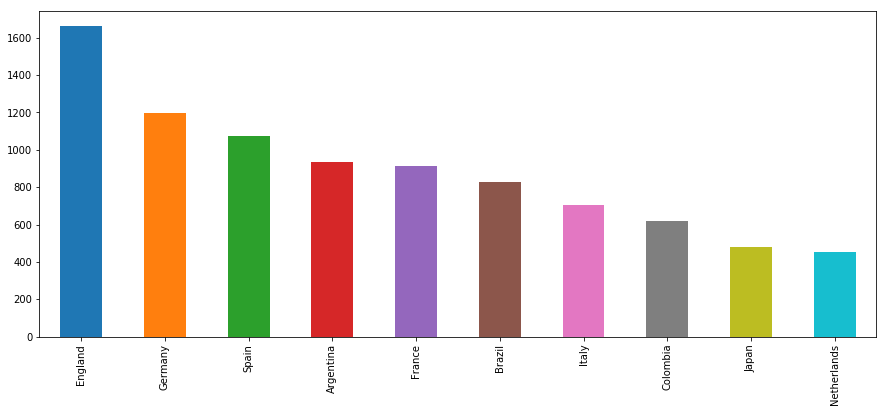

In [11]:
plt.figure(1 , figsize = (15 , 6))

fifa['Nationality'].value_counts()[:10].plot.bar()

In [18]:
fifa.sort_values(by = 'Age' , ascending = False)[['Name','Club','Nationality'
                                               ,'Overall', 'Age' ]].head(5)

,Name,Club,Nationality,Overall,Age
4741,O. Pérez,Pachuca,Mexico,71,45
18183,K. Pilkington,Cambridge United,England,48,44
17726,T. Warner,Accrington Stanley,Trinidad & Tobago,53,44
10545,S. Narazaki,Nagoya Grampus,Japan,65,42
7225,C. Muñoz,CD Universidad de Concepción,Argentina,68,41


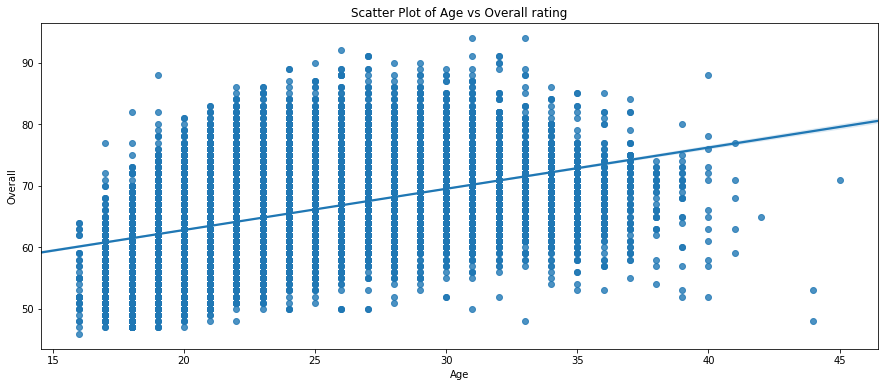

In [19]:
plt.figure(1 , figsize = (15 , 6))
sns.regplot(fifa['Age'] , fifa['Overall'])
plt.title('Scatter Plot of Age vs Overall rating')
plt.show()

In [24]:
from collections import Counter

In [27]:
c = Counter(fifa['Nationality']).most_common()[:11]

In [28]:
c

[('England', 1662),
 ('Germany', 1198),
 ('Spain', 1072),
 ('Argentina', 937),
 ('France', 914),
 ('Brazil', 827),
 ('Italy', 702),
 ('Colombia', 618),
 ('Japan', 478),
 ('Netherlands', 453),
 ('Sweden', 397)]

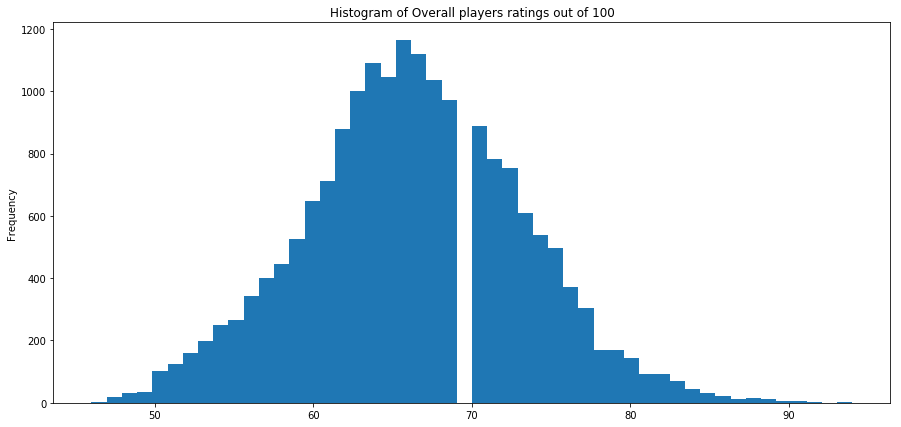

In [29]:
plt.figure(1 , figsize = (15 , 7))
fifa['Overall'].plot(kind = 'hist' , bins = 50 )
plt.title('Histogram of Overall players ratings out of 100')
plt.show()

In [36]:
best_players = pd.DataFrame(fifa.sort_values(by = 'Overall',ascending = False ).head(20))
best_players

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
5,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,https://cdn.sofifa.org/teams/2/light/5.png,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,Yes,LF,10.0,"Jul 1, 2012",NaN,2020,5'8,163lbs,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,8

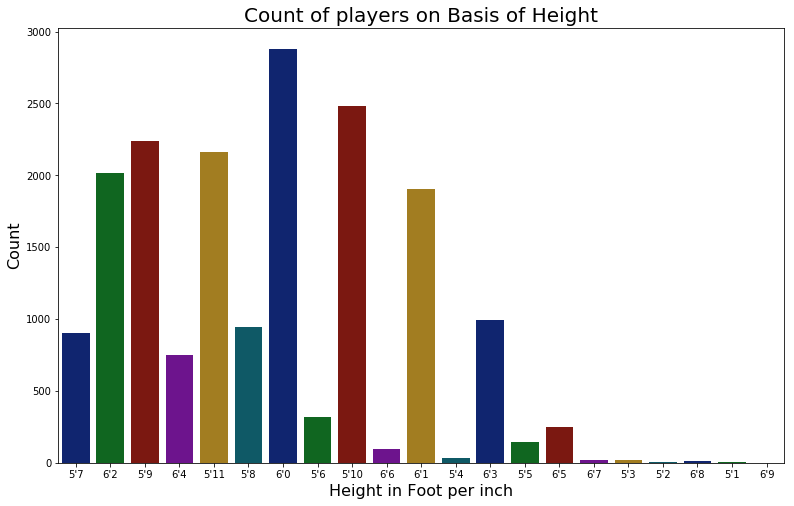

In [39]:
plt.figure(figsize = (13, 8))
ax = sns.countplot(x = 'Height', data = fifa, palette = 'dark')
ax.set_title(label = 'Count of players on Basis of Height', fontsize = 20)
ax.set_xlabel(xlabel = 'Height in Foot per inch', fontsize = 16)
ax.set_ylabel(ylabel = 'Count', fontsize = 16)
plt.show()

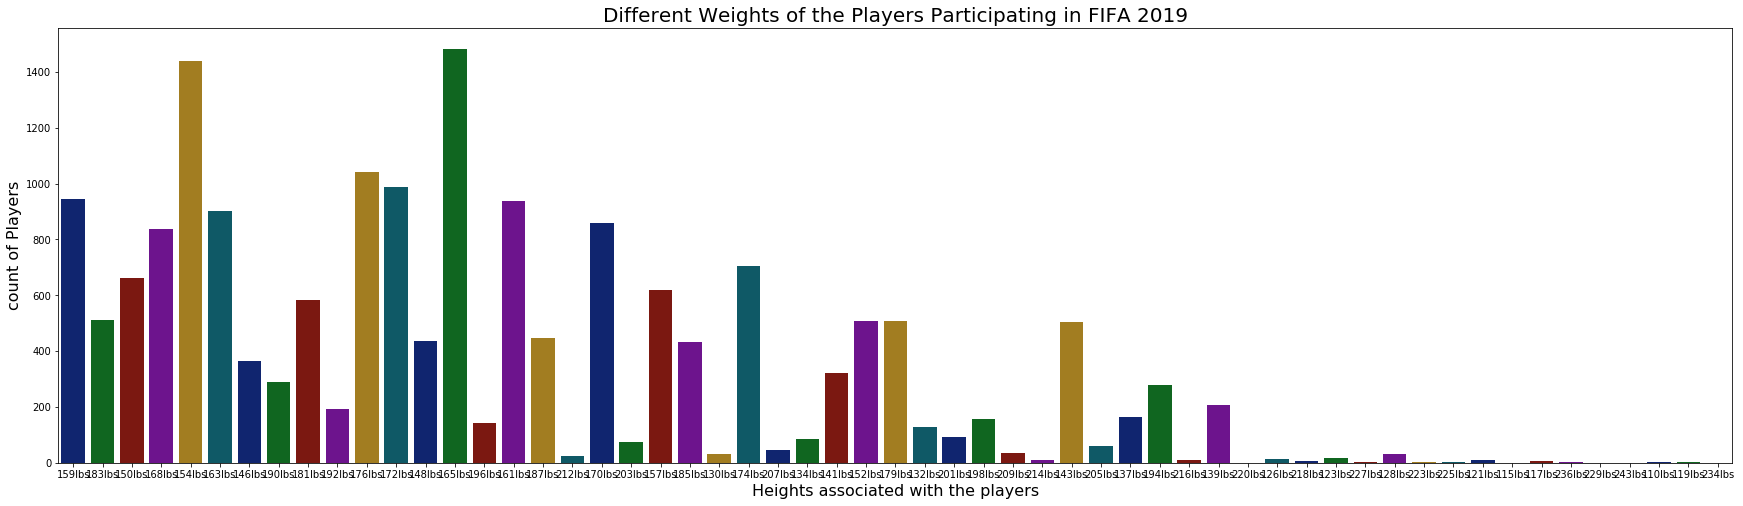

In [40]:
plt.figure(figsize = (30, 8))
sns.countplot(x = 'Weight', data = fifa, palette = 'dark')
plt.title('Different Weights of the Players Participating in FIFA 2019', fontsize = 20)
plt.xlabel('Heights associated with the players', fontsize = 16)
plt.ylabel('count of Players', fontsize = 16)
plt.show()

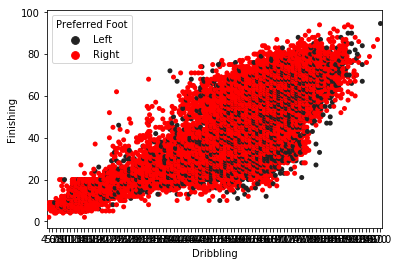

In [42]:
sns.swarmplot(x="Dribbling", y="Finishing",hue="Preferred Foot",data = fifa, color = 'red')
plt.show()

In [78]:
fifa1 = fifa1._get_numeric_data() #drop non-numeric cols
Y=fifa1.VALUE
X=fifa1.drop(['VALUE'], axis=1)
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
pd.DataFrame(list(sorted(zip(vif.VIF_Factor, vif.features))))

,0,1
0,1.123058,WeakFoot
1,1.180633,InternationalReputation
2,1.312224,Height
3,1.678138,Wage
4,2.172450,SkillMoves
5,2.674642,Weight
6,2.710853,Composure
7,4.313351,Potential
8,5.651856,Age
9,11.346361,Overall


In [69]:
vif.sort_values('VIF_Factor')

,VIF_Factor,features
43,1.123058,WeakFoot
42,1.180633,InternationalReputation
45,1.312224,Height
40,1.678138,Wage
44,2.172450,SkillMoves
46,2.674642,Weight
72,2.710853,Composure
39,4.313351,Potential
37,5.651856,Age
38,11.346361,Overall
